In [96]:
import os
import json
import logging
import string
import random
from typing import Annotated, Any, Dict, List, Literal, Optional, Callable

import sqlite3
from pydantic import BaseModel, Field, ConfigDict, field_validator
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain.chat_models import init_chat_model
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display, Markdown

In [2]:
path_to_openai_key:str = os.path.expanduser('~/.openai/api_key')
with open(path_to_openai_key, 'r', encoding='utf-8') as file:
    os.environ["OPENAI_API_KEY"] = file.read().strip()

MODEL: str = "openai/gpt-4o"

path_to_tavily_key:str = os.path.expanduser('~/.tavily/api_key')
with open(path_to_tavily_key, 'r', encoding='utf-8') as file:
    os.environ["TAVILY_API_KEY"] = file.read().strip()

In [3]:
class State(BaseModel):
    model_config = ConfigDict(frozen=False) # ToolNode needs to update state
    messages: List[BaseMessage] = Field(default_factory=list)

In [154]:
class Agent:
    def __init__(
        self,
        model,
        tools: List[Any],
        id: Optional[str] = None,
        persistency_path: str = "checkpoints.db",
        system_message: str = ""
    ):
        self.id = ''.join(random.choices(string.ascii_letters + string.digits, k=8)) if not id else id
        self.system_message = system_message
        self.tools = tools
        self.model = model.bind_tools(tools)
        
        # Internal DB Setup
        self.persistency_path = persistency_path
        self.conn = sqlite3.connect(persistency_path, check_same_thread=False)
        self.checkpointer = SqliteSaver(self.conn)
        
        # Build Graph
        graph = StateGraph(State)

        graph.add_node("get_request", self.get_request)
        graph.add_node("call_llm", self.call_llm)
        
        # USE PREBUILT TOOLNODE
        # We specify 'messages' as the key ToolNode should look at
        graph.add_node("tools", ToolNode(tools=self.tools))
        graph.add_node("llm_answer", self.llm_answer)
        graph.add_node("report", self.report)

        # Edges
        graph.set_entry_point("get_request")
        graph.add_conditional_edges(
            "get_request",
            self.should_continue,
            {
                "call_llm": "call_llm",
                "__end__": END
            }
            
        )
        graph.add_conditional_edges(
            "call_llm", 
            self.router,
            {
                "tools": "tools",
                "llm_answer": "llm_answer",
            }
        )
        
        graph.add_edge("tools", "report") 
        graph.add_edge("llm_answer", "report")
        graph.add_edge("report", "get_request")

        self.application = graph.compile(checkpointer=self.checkpointer)

    def display(self):
        display(Image(self.application.get_graph().draw_mermaid_png()))

    def get_request(self, state: State) -> Dict[str, Any]:
        print("-" * 100)
        user_input = input("What do you need? (Type 'exit' to stop): ").strip()
        return {
            "messages": [HumanMessage(content=user_input)]
        }

    def should_continue(self, state: State) -> Literal["call_llm", "__end__"]:
        last_message = state.messages[-1]
        if last_message.content.strip().lower() == "exit":
            print("User requested exit.")
            return "__end__"

        return "call_llm"
        

    def call_llm(self, state: State) -> Dict[str, Any]:
        print("--- LLM ---")
        # Convert state.messages to LiteLLM format
        llm_messages = [{"role": "system", "content": self.system_message}]
        for msg in state.messages:
            if isinstance(msg, HumanMessage):
                llm_messages.append({"role": "user", "content": msg.content})
            elif isinstance(msg, AIMessage):
                llm_messages.append({"role": "assistant", "content": msg.content, "tool_calls": msg.additional_kwargs.get("tool_calls")})
            elif isinstance(msg, ToolMessage):
                llm_messages.append({"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id})

        response = self.model.invoke(llm_messages)
        # print(f"call_llm result: {response}")
        return {
            "messages": [response]
        }

    def router(self, state: State) -> Literal["tools", "llm_answer", "__end__"]:
        print("--- Roputer ---")
        last_message = state.messages[-1]
        if len(getattr(last_message, "tool_calls", [])) > 0:
            print("--- Router decided call tools ---")
            return "tools"

        if last_message.content:
            print("--- Router decided display LLM answer ---")
            return "llm_answer"

        print("--- Router returns __end__ ---")
        return "__end__"

    def llm_answer(self, state: State) -> Dict[str, Any]:
        # return {"messages": [AIMessage(content=state.messages[-1].content)]}
        return {"messages": state.messages}

    def report(self, state: State) -> Dict[str, Any]:
        print("--- Report ---")
        last_message = state.messages[-1]
        if isinstance(last_message, AIMessage):
            print(f"AGENT: AIMessage:{last_message.content}")
        elif isinstance(last_message, ToolMessage):
            messages = json.loads(last_message.content)
            printer(last_message.content)
            # for msg in messages:
            #    display(Markdown(msg['content']))
            
        else:
            print(f"unexpected last_message:{type(last_message)}")
        return {}
    
    def close(self):
        if hasattr(self, 'conn') and self.conn:
            self.conn.close()

    def __enter__(self):
        """Context manager 'with' statement"""
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """
        Deterministic/guaranteed to be triggered at the Context Manager 'with' exit.
        """
        self.close()
        
    def __call__(self, config: Optional[Dict[str, Any]] = None):
        config = {"configurable": {"thread_id": self.id}} if not config else config
        return self.application.invoke(State(), config=config)

In [155]:
MODEL: str = 'gpt-4.1'
model = init_chat_model(f"openai:{MODEL}")
search = TavilySearchResults(max_results=4)

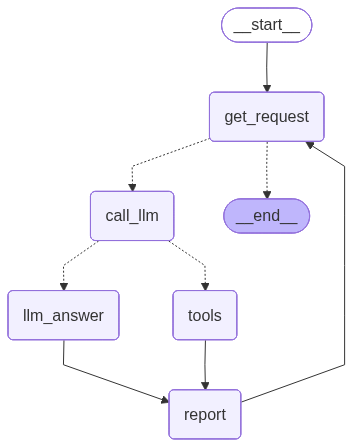

----------------------------------------------------------------------------------------------------


What do you need? (Type 'exit' to stop):  time in nyc


--- LLM ---
--- Roputer ---
--- Router decided call tools ---
--- Report ---


## Search Results Summary

| Score | Title | URL |
| :--- | :--- | :--- |
| 0.96 | [Current time in New York, United States - LogWork.com](https://logwork.com/current-time-in-new-york-united-states) | [Link](https://logwork.com/current-time-in-new-york-united-states) |
| 0.95 | [Time Now in New York City, United States](https://time.now/new-york-city/) | [Link](https://time.now/new-york-city/) |
| 0.94 | [What time is it in New York, United States right now? - 24 Time Zones](https://24timezones.com/New-York/time) | [Link](https://24timezones.com/New-York/time) |
| 0.76 | [Current Local Time in New York, New York, USA - Time and Date](https://www.timeanddate.com/worldclock/usa/new-york) | [Link](https://www.timeanddate.com/worldclock/usa/new-york) |


# Current Time in New York, United States

## Current Time in New York now, United States

### Thursday, 25 Dec 2025, Week 52, EST

Christmas Cards [...] SUNRISE

07:17:58

SUNSET

16:33:58

TRANSIT

11:55:58

CIVIL TWILIGHT BEGIN

06:47:08

CIVIL TWILIGHT END

17:04:48

NAUTICAL TWILIGHT BEGIN

06:12:41

NAUTICAL TWILIGHT END

17:39:15

ASTRONOMICAL TWILIGHT BEGIN

05:39:22

ASTRONOMICAL TWILIGHT END

18:12:34

### New York, United States (New York) on the Map

### 50 Largest Cities From United States [...] |  |  |
 --- |
| Location | New York, New York |
| Location Lat/Long | 40.6943 / -73.9249 |
| Country Name | United States |
| Native Name | United States |
| Capital City | Washington |
| Region | Americas |
| Subregion | Northern America |
| Country Flag | 🇺🇸 |
| Country Flag Unicode | U+1F1FA U+1F1F8 |
| Currency | USD |
| Currency Symbol | $ |
| Phone Code | 1 |
| Top Level Domain | .us |
| Latitude / Longitude | 38.00000000 / -97.00000000 |

📅 Setting up meetings across time zones? Use our Event Planner for seamless coordination!

# Current Time in New York City, United States 🇺🇸

Lat/Long:
40.71° N,
74.01° W

State:
New York

Country:
🇺🇸 United States

IANA Timezone:
America/New\_York

UTC Offset:
−05:00

Timezone: 
EST

Daylight Saving Time:
No ❌

Standard Timezone Abbreviations used in United States:
AKST,
CST,
EST,
HST,
MST,
PST

Daylight Saving Timezone Abbreviations used in United States:
AKDT,
CDT,
EDT,
HDT,
MDT,
PDT [...] ## Time now in other cities in United States:

### Tools & Converters

## Moon Phases & Times for New York City

View the detailed moon calendar for New York City with moonphases, moonrise, and moonset times for any date.

## Time now in other major cities in 🇺🇸 United States:

Free widgets for webmasters:

2025 © Time.now - ⌚ Time now is XX:YY:ZZ

World Time

United States

New York

New York

# Current local time in New York

New York

ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ

## New York - local time right now, summer/winter time conversion dates in 2026

### Local time

--:--
EST

### New York summer time (DST) in 2026

| Daylight saving time 2026 in New York begins at 2:00 AM on Sunday, March 08 | Set your clock forward 1 hour |
| It ends at 2:00 AM on Sunday, November 01 | Set your clock back 1 hour |

### New York time zone [...] |  |  |
 --- |
| Latitude: | 40° 43' North |
| Longitude: | 74° 0' West |
| Population: | 8175133 |
| Elevation: | 10 meters |

New York online map

New York online map

New York online map

Time at locations near New York time zone : Toronto, Montreal, Philadelphia, Port-au-Prince, Kingston, Jacksonville, Columbus, Indianapolis, Charlotte, Ottawa [...] Correct local time in New York, United States timezone, official time change dates winter time 2026 daylight saving dates, DST, clock change, GMT/UTC difference.

Copyright © 2005 - 2025 24TimeZones.com. All rights reserved.

timeanddate.com
Flag for USA

# Current Local Time in New York, New York, USA

Thursday, December 25, 2025

|  |  |
 --- |
| Country: | United States |
| State: | New York (NY) |
| Lat/Long: | 40°43'N / 74°01'W |
| Elevation: | 8 m |
| Currency: | United States Dollar (USD) |
| Languages: | English |
| Country Code: | +1 |

Location of New York
Location

Holiday Note: Dec 25, Christmas Day. Businesses may be closed. See more

## Weather

Clear.  
44 / 26 °F [...] |  |  |  |
 --- 
| Fri 26. |  | 27 / 20 °F |
| Sat 27. |  | 32 / 21 °F |

Weather by CustomWeather, © 2025

More weather details

## Time Zone

Daylight Saving Time started on Sunday, March 9, 2025 at 2:00 am

## DST started

Daylight Saving Time ended on Sunday, November 2, 2025 at 2:00 am

## DST ended

## Difference

About EST — Eastern Standard Time

Set your location

## Sunrise

## Sunset

## Day length

## Moon 25.4%

## High Tide

## Low Tide [...] More Sun & Moon in New York  
+ Show More Twilight and Moon Phase Information

## Solar Noon

## Astronomical Twilight

## Nautical Twilight

## Civil Twilight

## Previous Moon Phase

## Next Moon Phase

Need some help?

## Tools & Converters

## Calendar & Holidays

Create the United States calendar

### Upcoming Holidays

More Holidays in the United States

## Airports

Other cities near New York

timeanddate.com logo

Illustration of a pink shield with a white heart.

# Current Time in New York, United States

## Current Time in New York now, United States

### Thursday, 25 Dec 2025, Week 52, EST

Christmas Cards [...] SUNRISE

07:17:58

SUNSET

16:33:58

TRANSIT

11:55:58

CIVIL TWILIGHT BEGIN

06:47:08

CIVIL TWILIGHT END

17:04:48

NAUTICAL TWILIGHT BEGIN

06:12:41

NAUTICAL TWILIGHT END

17:39:15

ASTRONOMICAL TWILIGHT BEGIN

05:39:22

ASTRONOMICAL TWILIGHT END

18:12:34

### New York, United States (New York) on the Map

### 50 Largest Cities From United States [...] |  |  |
 --- |
| Location | New York, New York |
| Location Lat/Long | 40.6943 / -73.9249 |
| Country Name | United States |
| Native Name | United States |
| Capital City | Washington |
| Region | Americas |
| Subregion | Northern America |
| Country Flag | 🇺🇸 |
| Country Flag Unicode | U+1F1FA U+1F1F8 |
| Currency | USD |
| Currency Symbol | $ |
| Phone Code | 1 |
| Top Level Domain | .us |
| Latitude / Longitude | 38.00000000 / -97.00000000 |

📅 Setting up meetings across time zones? Use our Event Planner for seamless coordination!

# Current Time in New York City, United States 🇺🇸

Lat/Long:
40.71° N,
74.01° W

State:
New York

Country:
🇺🇸 United States

IANA Timezone:
America/New\_York

UTC Offset:
−05:00

Timezone: 
EST

Daylight Saving Time:
No ❌

Standard Timezone Abbreviations used in United States:
AKST,
CST,
EST,
HST,
MST,
PST

Daylight Saving Timezone Abbreviations used in United States:
AKDT,
CDT,
EDT,
HDT,
MDT,
PDT [...] ## Time now in other cities in United States:

### Tools & Converters

## Moon Phases & Times for New York City

View the detailed moon calendar for New York City with moonphases, moonrise, and moonset times for any date.

## Time now in other major cities in 🇺🇸 United States:

Free widgets for webmasters:

2025 © Time.now - ⌚ Time now is XX:YY:ZZ

World Time

United States

New York

New York

# Current local time in New York

New York

ㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤㅤ

## New York - local time right now, summer/winter time conversion dates in 2026

### Local time

--:--
EST

### New York summer time (DST) in 2026

| Daylight saving time 2026 in New York begins at 2:00 AM on Sunday, March 08 | Set your clock forward 1 hour |
| It ends at 2:00 AM on Sunday, November 01 | Set your clock back 1 hour |

### New York time zone [...] |  |  |
 --- |
| Latitude: | 40° 43' North |
| Longitude: | 74° 0' West |
| Population: | 8175133 |
| Elevation: | 10 meters |

New York online map

New York online map

New York online map

Time at locations near New York time zone : Toronto, Montreal, Philadelphia, Port-au-Prince, Kingston, Jacksonville, Columbus, Indianapolis, Charlotte, Ottawa [...] Correct local time in New York, United States timezone, official time change dates winter time 2026 daylight saving dates, DST, clock change, GMT/UTC difference.

Copyright © 2005 - 2025 24TimeZones.com. All rights reserved.

timeanddate.com
Flag for USA

# Current Local Time in New York, New York, USA

Thursday, December 25, 2025

|  |  |
 --- |
| Country: | United States |
| State: | New York (NY) |
| Lat/Long: | 40°43'N / 74°01'W |
| Elevation: | 8 m |
| Currency: | United States Dollar (USD) |
| Languages: | English |
| Country Code: | +1 |

Location of New York
Location

Holiday Note: Dec 25, Christmas Day. Businesses may be closed. See more

## Weather

Clear.  
44 / 26 °F [...] |  |  |  |
 --- 
| Fri 26. |  | 27 / 20 °F |
| Sat 27. |  | 32 / 21 °F |

Weather by CustomWeather, © 2025

More weather details

## Time Zone

Daylight Saving Time started on Sunday, March 9, 2025 at 2:00 am

## DST started

Daylight Saving Time ended on Sunday, November 2, 2025 at 2:00 am

## DST ended

## Difference

About EST — Eastern Standard Time

Set your location

## Sunrise

## Sunset

## Day length

## Moon 25.4%

## High Tide

## Low Tide [...] More Sun & Moon in New York  
+ Show More Twilight and Moon Phase Information

## Solar Noon

## Astronomical Twilight

## Nautical Twilight

## Civil Twilight

## Previous Moon Phase

## Next Moon Phase

Need some help?

## Tools & Converters

## Calendar & Holidays

Create the United States calendar

### Upcoming Holidays

More Holidays in the United States

## Airports

Other cities near New York

timeanddate.com logo

Illustration of a pink shield with a white heart.

----------------------------------------------------------------------------------------------------


What do you need? (Type 'exit' to stop):  exit


User requested exit.


In [159]:
with Agent(model=model, system_message="", tools=[search]) as agent:
    agent.display()
    agent()

In [ ]:
#Agent(model=model, system_message="", tools=[search])()

In [158]:
import ast
from IPython.display import display, Markdown

def printer(raw_data):
    data = ast.literal_eval(raw_data)
    
    # 2. Build the Markdown Table
    table_md = "| Score | Title | URL |\n| :--- | :--- | :--- |\n"
    
    for entry in data:
        # We truncate the title if it's too long and format the link
        short_title = (entry['title'][:75] + '..') if len(entry['title']) > 75 else entry['title']
        link = f"[{short_title}]({entry['url']})"
        score = f"{entry['score']:.2f}" # Format score to 2 decimal places
        
        table_md += f"| {score} | {link} | [Link]({entry['url']}) |\n"
    
    # 3. Render
    display(Markdown("## Search Results Summary"))
    display(Markdown(table_md))
    
    # 4. Optional: Display detailed content in collapsible sections
    for entry in data:
        display(Markdown(entry['content']))